# Optimum Filter Demo: NxMx1 Covariance Matrix

Author: Maggie Reed, maggie_reed@berkeley.edu

Last updated: 07/03/2024

-----

UNDERCONSTRUCTION! DETPROCESS SIGNAL PROCESSING IS NOT IMPLEMENTED YET.

# Overview and Purpose

This demo notebook is for Spice/Herald members who wish to utilize the NxMx1 covariance matrix for optimum filter formalism. 

blahblahstuff about filters and the nxm 

# Setup

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import qetpy as qp
import pytesdaq
import numpy as np
from qetpy.core import OFnxm
from qetpy.core import OFBase

In [3]:
save_dict_name = 'didvresult_muon_example'
with open(save_dict_name, 'rb') as handle:
    offsets_dict = pickle.load(handle)

In [4]:
fs=1.25e6
f = np.fft.fftfreq(32768, d=1/fs)
noisesim = qp.sim.TESnoise(freqs=f, didv_result=offsets_dict)
psd_sim = noisesim.s_iload(freqs=f) + noisesim.s_ites(freqs=f) + noisesim.s_itfn(freqs=f)
# create 100 noise traces for each pulse
noise = qp.gen_noise(psd_sim, fs=fs, ntraces=100)
noise2 = qp.gen_noise(psd_sim, fs=fs, ntraces=100)

f_fold, psd_sim_fold = qp.foldpsd(psd_sim, fs=fs)

# create a template
pulse_amp = 1.6e-6 # [A]
tau_f = 66e-6 # [s]
tau_r = 20e-6 # [s]

t = np.arange(len(psd_sim))/fs
pretrigger_samples = len(t)//2
pulse = np.exp(-t/tau_f)-np.exp(-t/tau_r) #just the basic equation for a pulse
pulse_shifted = np.roll(pulse, len(t)//2) #shifting the pulse to the center of t
template = pulse_shifted/pulse_shifted.max() #normalized template to max height of pulse
# use the PSD to create an example trace to fit
signal_1 = noise[0] + np.roll(template, 160)*pulse_amp # note the shift we have added, 160 us

# create a second signal, different shape, same length. Signal occurs at same time. 
# noise is the exact same 
pulse_amp = 1.6e-6 # [A]
tau_f = 120e-6 # [s]
tau_r = 20e-6 # [s]
pulse = np.exp(-t/tau_f)-np.exp(-t/tau_r)
pulse_shifted = np.roll(pulse, len(t)//2)
template2 = pulse_shifted/pulse_shifted.max()
signal_2 = noise2[0] + np.roll(template2, 160)*pulse_amp 

Automatically determining G
P0 = 50.72686520007603 fW
G = 6.340858150009502e-12 W/K
Calculating dVdI
Calculating dPdI


/home/serfass/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1731: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[0] = _ddi0_dPdI_3(didv_result, f)
/home/serfass/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1732: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[1] = _ddr0_dPdI_3(didv_result, f)
/home/serfass/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1733: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[2] = _dddVdI_dPdI_3(didv_result, f)
/home/serfass/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1734: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[3] = _ddbeta_dPdI_3(didv_result, f)
/home/serfass/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1735: ComplexWarning

Done calculating dVdI and dPdI


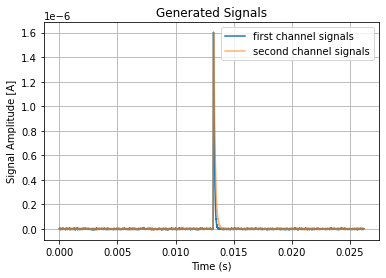

In [5]:
plt.plot(t, signal_1, label='first channel signals')
plt.plot(t, signal_2, alpha=0.6,label='second channel signals')
plt.ylabel("Signal Amplitude [A]")
plt.xlabel("Time (s)")
plt.grid()
plt.legend()
plt.title('Generated Signals')
plt.show()

In [6]:
nchans=2
nbins=len(signal_1)

avgnoise_matrix = np.zeros((100,nchans,nbins)) #calculating csd from 100 traces of noise
avgnoise_matrix[:,0,:] = noise
avgnoise_matrix[:,1,:] = noise2

chans = ['signal1','signal2']
NC = qp.Noise(avgnoise_matrix, fs, chans)
NC.calculate_csd(twosided=True) #csd is returned in A^2/Hz
csd = NC.csd

noise_matrix = np.zeros((nchans,nbins))
noise_matrix[0,:]=noise[0] #just taking one noise trace
noise_matrix[1,:]=noise2[0]

# 2x2

In [7]:
# signals (nchans, nbins)
# should be an array (2,32768)
signal = np.array([signal_1, signal_2])
print(f'Signal matrix shape = {signal.shape}')
# templates (nchans, ntmps, nbins)
# should be a (2,2,32768) array

off_diagn_terms = np.zeros_like(template)
templates = np.asarray([[template, off_diagn_terms],[off_diagn_terms,template2]])
print(f'Template matrix shape = {templates.shape}')

# channels 
#  format:
#   - string 'chan1|chan2' 
#   - OR list ['chan1', 'chan2']
channels = ['signal_1', 'signal_2']
#channels = 'signal_1 | signal_2'

pretrigger_samples = nbins//2


Signal matrix shape = (2, 32768)
Template matrix shape = (2, 2, 32768)


In [8]:
ofnxm = OFnxm(channels=channels, templates=templates, 
              csd=csd,sample_rate=fs, 
              pretrigger_samples=pretrigger_samples)

INFO: Adding templates with shape=(2, 2, 32768) to OF base object!
INFO: Adding noise CSD to OF base object


In [9]:
# calc
ofnxm.calc(signal=signal)

# get fit result
amp, t0, chi2 = ofnxm.get_fit_withdelay()
print(f"With Delay Fit: amp = {amp*1e6} uA, t_0 = {t0*1e6} us, chi^2 = {chi2}")


With Delay Fit: amp = [1.59920634 1.59928767] uA, t_0 = 128.0 us, chi^2 = 66570.91465937346


# 2x1

In [10]:
templates = np.array([[template],[off_diagn_terms]])
signal = np.array([signal_1, noise2[0]]) #our signal on the second channel is just noise
print(f'Template matrix shape = {templates.shape}')
print(f'Signal matrix shape = {signal.shape}')
# channels 
#  format:
#   - string 'chan1|chan2' 
#   - OR list ['chan1', 'chan2']
channels = ['signal_1', 'signal_2']
#channels = 'signal_1 | signal_2'


pretrigger_samples = nbins//2

Template matrix shape = (2, 1, 32768)
Signal matrix shape = (2, 32768)


In [11]:
ofnxm = OFnxm(channels=channels, templates=templates,
              csd=csd,sample_rate=fs, 
              pretrigger_samples=pretrigger_samples)

INFO: Adding templates with shape=(2, 1, 32768) to OF base object!
INFO: Adding noise CSD to OF base object


In [12]:
# calc
ofnxm.calc(signal=signal)

# get fit results
amp, t0, chi2 = ofnxm.get_fit_withdelay()
print(f"With Delay Fit: amp = {amp*1e6} uA, t_0 = {t0*1e6} us, chi^2 = {chi2}")

With Delay Fit: amp = [1.59920792] uA, t_0 = 128.0 us, chi^2 = 66571.90734397806
